# Démonstration: Fit d'un spectre de rayonnement thermique

Comme dans le cas du spectre de luminescence du rubis, nous allons commencer par importer les modules qui seront nécessaires à notre analyse. Il s'agit des modules:
* `numpy` pour les mathématiques, la gestion des tableaux et l'ouverture de fichiers
* `matplotlib` pour le tracé graphique
* `scipy`, une bibliothèque pour le calcul scientifique, ici nous utiliserons la fonction `curve_fit` qui sert aux regression non linéaires


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ces deux dernières lignes permettent de tracer des figures de bonne qualité (format vectoriel) directement dans le notebook :
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

On a ici procédé à 2 types d'import:

* le format `import module as alias` pour importer un module et toutes ses méthodes (fonctionnalités), que l'on pourra appeler en utilisant `alias.methode`.
* le format `from module import methode` qui permet de n'importer qu'une seule fonctionnalité, que l'on pourra appeler directement.

Notons que certains modules ont un format de "packages", c'est à dire qu'ils contiennent des sous-modules : c'est le cas par exemple dans l'instruction `from scipy.optimize import curve_fit` où seule la fonction `curve_fit` issue du sous-module `optimize` de `scipy` est chargée.

## Chargement du fichier de données

On commence par charger le fichier de données obtenu par la mesure de pyrométrie optique. Il s'agit d'un fichier texte qui contient deux colonnes : les longueurs d'onde en nm, et les intensités (en unité arbitaire).

In [2]:
# Read data from text file:
# les colonnes sont séparées par le caractère tab, codé par \t
data = np.loadtxt('data_planck.txt', delimiter='\t')

# La première colonne correspond aux longueurs d'ondes:
x_data = data[:,0]
# La seconde aux intensités:
y_data = data[:,1]

# affichons un aperçu des tableaux obtenus:
# l'instruction \n permet d'aller à la ligne
print('x: \n', x_data)
print('y: \n', y_data)

x: 
 [1073.5483087  1073.12515448 1072.70200025 ...  507.79110842  507.36795419
  506.94479997]
y: 
 [1.53097845e+10 2.09920867e+10 1.81776010e+10 ... 1.34773746e+10
 4.56444231e+09 7.96551438e+09]


## Tracé des données

Nous utilisons la bibliothèque `matplotlib` afin de visualiser les données. Nous y ajoutons des étiquettes d'axes et une légende.

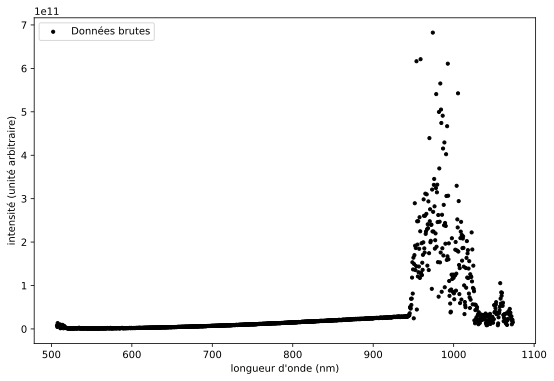

In [3]:
# on crée une figure et on précise ses dimensions (largeur,hauteur) :
plt.figure(figsize=(9,6))

plt.scatter(x_data, 
            y_data, 
            color='k', # k = black
            s=10,      # taille des points
            label='Données brutes') 

plt.xlabel("longueur d'onde (nm)")
plt.ylabel("intensité (unité arbitraire)")

plt.legend()
plt.show()

On remarque immédiatement des artefacts de mesure en dessous de 520 nm et au dessus de 930 nm, principalement dus à l'utilisation de filtres sur le trajet optique. Nous allons exclure ces régions de notre ajustement. 

## Selection de la partie utile des données

La condition `x_data > 520` renvoie un tableau de booléens de même longueur que `x_data`, contenant `True` ou `False` pour chacun des élements de `x_data`. 
Nous pouvons combiner plusieurs conditions de ce type, en utilisant les opérateurs `&` (et logique), `|` (ou logique) :
```
(x_data < 520) & (x_data > 930)
```
Nous pouvons utiliser cette condition pour sélectionner les données utiles de la façon suivante:

In [4]:
x_use = x_data[(x_data > 520) & (x_data < 930)]

# nous pouvons utiliser la même condition sur x pour filtrer y, car il y a correspondance biunivoque :
y_use = y_data[(x_data > 520) & (x_data < 930)] 

On trace ce nouveau jeu de données, restreint à l'intervale de longueur d'onde $[520, 930]$ nm, dans une nouvelle figure :

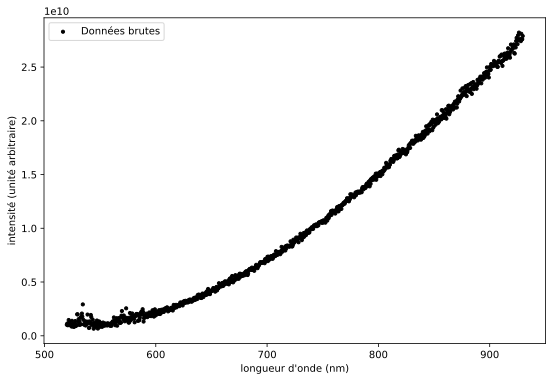

In [5]:
# on crée une nouvelle figure et on précise ses dimensions (largeur,hauteur) :
plt.figure(figsize=(9,6))

plt.scatter(x_use, 
            y_use, 
            color='k', # k = black
            s=10,      # taille des points
            label='Données brutes') 

plt.xlabel("longueur d'onde (nm)")
plt.ylabel("intensité (unité arbitraire)")

plt.legend()
plt.show()

## Ajustement par la loi de Planck

Le spectre est déjà normalisé par la fonction de transfert du montage expérimental, préalablement calibré. Il peut donc directement être analysé avec la loi de Planck. On définit la loi de Planck,

$\LARGE I = \varepsilon \frac{2\pi h c^2}{\lambda^5} \frac{1}{e^{h c / \lambda k T} -1}$

sous la forme d'une fonction à trois variables, la longueur d'onde, l'émissivité $\varepsilon$ et la température $T$ que l'on cherche à déterminer. 
On se place dans l'approximation d'un corps gris, dont l'émissivité ne dépends pas de la longueur d'onde mais est une constante telle que $0<\varepsilon<1$. L'émissivité et la température seront ajustées lors du fit.

In [6]:
# définition des constantes nécessaires: 

h = 6.62607015e-34 # Planck's constant in J/s
c = 299792458 # Speed of light in m/s
k = 1.380649 * 1e-23 # Boltzmann constant in J/K


# définition de la fonction:

def planck(lamb, eps, temp):  # lamb doit être donné en mètres 
    f =  ( eps * ( 2*np.pi*h*c**2 / (lamb**5) ) * 
         1 / ( np.exp(h * c / (lamb * k * temp)) - 1 ) )
    return f

Nous utilisons la fonction `curve_fit` du module `scipy.optimize` pour réaliser le fit :

In [7]:
# on définit un jeu de paramètres initiaux pour le fit:
p_init = (0.5, 2000)   # epsilon, temp

# on peut ajouter des bornes limites aux paramètres:
p_bounds = ( (0, 1000), # valeurs minimales de (epsilon, temp)
             (1, 5000)) # valeurs maximales de (epsilon, temp)


# On appelle la fonction curve_fit, dont les arguments sont ici:
# curve_fit(modèle, x, y, p0 = paramètres initiaux, bounds=bornes)
# cette fonction renvoie deux sorties: le jeu des paramètres optimisés, et la matrice de covariance 

p_fit, cov_fit = curve_fit(planck, x_use*1e-9, y_use, p0 = p_init, bounds = p_bounds)

print('Résultats du fit :')
print('epsilon  = ', p_fit[0])
print('temp     = ', p_fit[1], 'K')

Résultats du fit :
epsilon  =  0.2526028180574458
temp     =  1822.1703983064635 K


On réalise une nouvelle figure qui contient les données brutes et le résultat du fit. On souhaite aussi visualiser les résidus du fit dans un second panneau.  Pour cela, nous utilisons la syntaxe `fig, axs = plt.suplots(2)` qui permet de générer une figure avec deux panneaux.

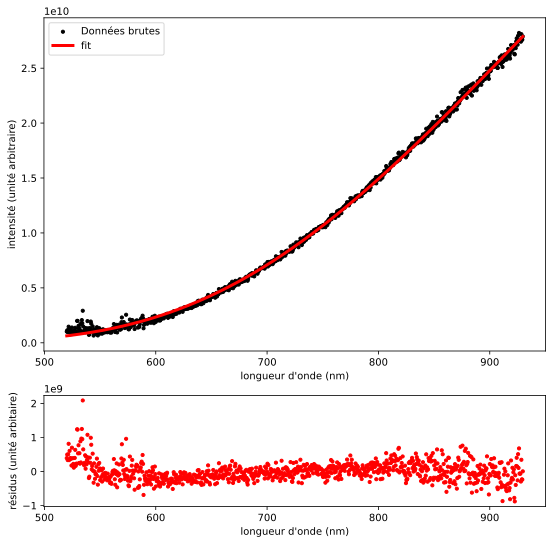

In [8]:
# Nous utilisons la syntaxe fig, ax = plt.subplots(2, ...)
fig, axs = plt.subplots(2, figsize=(9, 9), height_ratios=(3,1))

# nous allons tracer nos courbe en appelant l'objet 'axs' dont les élements sont les panneaux:
axs[0].scatter(x_use, 
               y_use, 
               color='k', # k = black
               s=10,      # taille des points
               label='Données brutes') 

axs[0].plot(x_use, 
            planck(1e-9*x_use, p_fit[0], p_fit[1]),
            linewidth=3,   # épaisseur du trait
            color='r', # r = red
            label='fit')

# on calcule les résidus :
res = y_use - planck(1e-9*x_use, p_fit[0], p_fit[1])

# on trace les résidus dans le second paneau :
axs[1].scatter(x_use, 
               res,
               color='r',
               s = 10)



# notons la syntaxe qui change légèrement ici pour les objets axs, pour lesquels on utilise set_xlabel...
axs[0].set_xlabel("longueur d'onde (nm)")
axs[0].set_ylabel("intensité (unité arbitraire)")

axs[1].set_xlabel("longueur d'onde (nm)")
axs[1].set_ylabel("résidus (unité arbitaire)")

axs[0].legend()
plt.show()

Nous pouvons maintenant calculer l'erreur de fit sur les paramètres à partir de la matrice de covariance. Celle-ci à été définie lors de l'appel à la fonction `curve_fit` (voir plus haut), et stockée dans `cov_fit`. 

In [9]:
print(cov_fit)

[[ 3.76640731e-06 -2.89242618e-03]
 [-2.89242618e-03  2.23740142e+00]]


Les éléments de la matrice de covariance non-diagonaux sont faibles, ce qui traduit l'indépendance des paramètres $\varepsilon$ et $T$, et est rassurant sur la qualité de notre fit.  Pour calculer les erreurs (écarts-type) sur les paramètres obtenus, on prends la racine des élements diagonaux :

In [10]:
err_fit = np.sqrt( np.diag(cov_fit) )

print('err_fit = ', err_fit)

# présentons nos résultats :
# Nous pouvons arrondir les valeurs avec la fonction np.round(x, nombre_de_décimales)

print('\n') # saut de ligne
print('Résultats du fit :')
print('temp     = ', np.round(p_fit[1], 1), '+/-', np.round(err_fit[1], 1), 'K')
print('epsilon  = ', np.round(p_fit[0], 2), '+/-', np.round(err_fit[0], 2))

err_fit =  [0.00194072 1.49579458]


Résultats du fit :
temp     =  1822.2 +/- 1.5 K
epsilon  =  0.25 +/- 0.0


Notons que ces erreurs sont seulement des erreurs mathématiques d'ajustement, __et sont beaucoup plus faibles que la véritable barre d'erreur expérimentale sur la température.__ 

## Pour aller plus loin

Dans cette section, nous allons approfondir notre analyse du spectre avec :
* Un fit dans l'approximation de Wien
* Une analyse par pyrométrie deux-couleurs, qui permettra de quantifier l'erreur de mesure sur la température

Ces analyses sont basées sur la méthode présentée dans [Benedetti & Loubeyre, High Pressure Research __24__ 423-445 (2004)](https://www.tandfonline.com/doi/abs/10.1080/08957950412331331718).



### Fit dans l'approximation de Wien

Dans l'approximation de Wien on considère que la température est suffisemment faible pour que $\large e^{hc/\lambda kT} >> 1$. 
Dans ce cas on a :
$$
 \Large I \approx \varepsilon \frac{2\pi h c^2}{\lambda^5} \frac{1}{e^{h c / \lambda k T}} 
$$
En réarrangeant on peut définir la quantité :
$$
\Large Wien = \frac{k}{hc} \ln{\left(\frac{2 \pi h c^2}{I \lambda^5}\right)} = \frac{1}{T}  \frac{1}{\lambda} - \frac{k}{hc} \ln{\varepsilon}
$$

Ainsi la quantité $Wien (1/\lambda)$ est une droite de pente $1/T$. Nous allons calculer cette quantité et réaliser un fit linéaire pour obtenir une seconde détermination de $T$ et de $\varepsilon$.  Commençons par définir la fonction $Wien$, appliquons là à nos données et traçons la fonction $Wien (1/\lambda)$ :

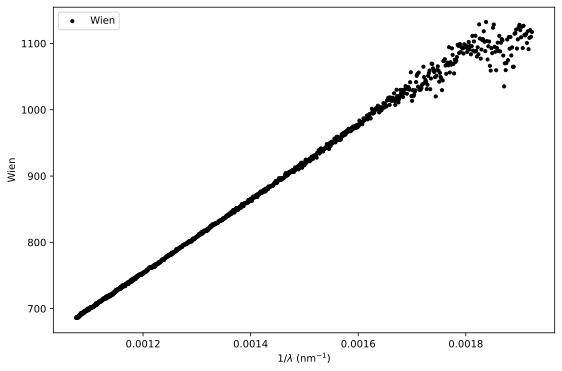

In [11]:
def wien(lamb, I):
    f = (k / (h*c)) * np.log(2 * np.pi * h * c**2 / (I * lamb**5) )
    return f

# Remarque : lambda doit être en unité SI
y_wien = wien(1e-9*x_use, y_use)


plt.figure(figsize=(9,6))

plt.scatter(1/x_use, 
            y_wien, 
            color='k', # k = black
            s=10,      # taille des points
            label='Wien') 

plt.xlabel("1/$\lambda$ (nm$^{-1}$)")
plt.ylabel("Wien")

plt.legend()
plt.show()

Pour réaliser un fit linéaire, nous pouvons utiliser la fonction `np.polyfit` du module `numpy` qui permet de réaliser des fits polynomiaux. Nous traçons les données avec le résultat du fit dans une nouvelle figure, avec un second panneau qui contiendra les résidus du fit. 

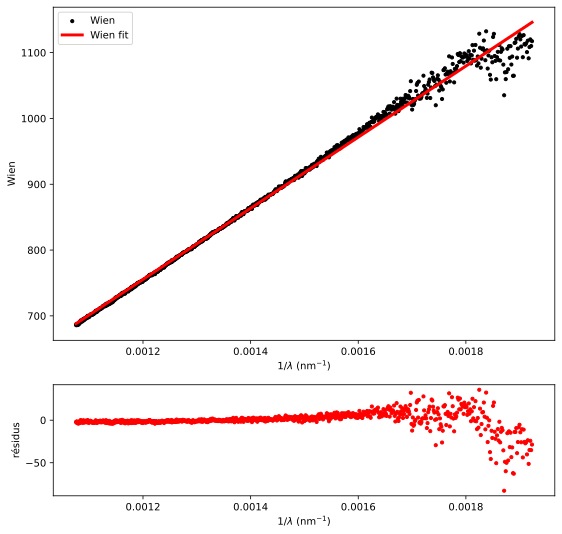

In [12]:
# La fonction retourne les coefficient du polynome par degres décroissants:
# le dernier paramètre est l'ordre du polynome : ici 1

a, b = np.polyfit(1/x_use, y_wien, 1)

fig, axs = plt.subplots(2, figsize=(9, 9), height_ratios=(3,1))

axs[0].scatter(1/x_use, 
               y_wien, 
               color='k', # k = black
               s=10,      # taille des points
               label='Wien') 

# on trace le fit :
axs[0].plot(1/x_use, 
            a/x_use + b,
            linewidth=3,   # épaisseur du trait
            color='r', # r = red
            label='Wien fit')

# on calcule les résidus :
res = y_wien - (a/x_use + b)

# on trace les résidus dans le second paneau :
axs[1].scatter(1/x_use, 
               res,
               color='r',
               s = 10)

# notons la syntaxe qui change légèrement ici pour les objets axs, pour lesquels on utilise set_xlabel...
axs[0].set_xlabel("1/$\lambda$ (nm$^{-1}$)")
axs[0].set_ylabel("Wien")

axs[1].set_xlabel("1/$\lambda$ (nm$^{-1}$)")
axs[1].set_ylabel("résidus")

axs[0].legend()

On obtient, en remarquant que 
* $\large T = 1/a$ 
* $\large \varepsilon = e^{-hcb/k}$

In [13]:
temp_wien = 1e9/a  # 1e9 car nous avons fitté la loi avec lambda en nm
epsilon_wien = np.exp(- h*c*b/k)

print('Résultats du fit dans l approximation de Wien :')
print('T        =  ', np.round(temp_wien, 1), 'K')
print('epsilon  =  ', np.round(epsilon_wien, 2))

Résultats du fit dans l approximation de Wien :
T        =   1851.0 K
epsilon  =   0.21


Ces valeurs sont en bon accord avec celles obtenues lors du fit de la loi de Planck : $T = 1822~K$ et $\varepsilon = 0.25$. Notons qu'aux grandes valeurs de $1/\lambda$ le fit est moins bon. Réalisons un second fit dans la région où $1/\lambda < 0.0017$ nm$^{-1}$ :

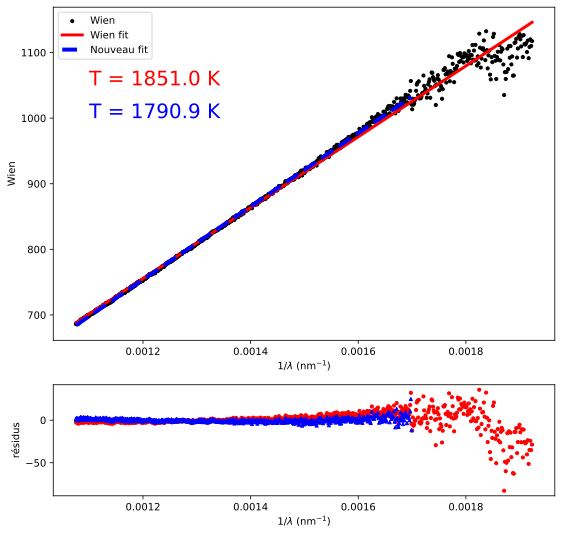

In [14]:
# selection des données 1/lambda < 0.0017 :
x1 = (1/x_use)[(1/x_use) < 0.0017]
y1 = y_wien[(1/x_use) < 0.0017]

a1, b1 = np.polyfit(x1, y1, 1)

# rajoutons ce fit à notre précédent plot, en bleu
axs[0].plot(x1, 
            a1*x1 + b1, 
            color='blue',
            linewidth=4,
            linestyle='dashed',
            label='Nouveau fit')

# on re-génère la légende :
axs[0].legend()

# on calcule les résidus avec ce nouveau fit et on trace :
res1 = y1 - (a1*x1 + b1)

axs[1].scatter(x1, 
               res1,
               color='b',
               marker='^', # symbole triangle
               s = 10)


# ajoutons les résultats directement sur la figure:
# ancien fit en rouge:
axs[0].text(0.0011, 
            1050 , 
            'T = ' + str(np.round(1e9/a, 1)) + ' K',
            size = 20,
            color = 'r')

# nouveau fit en bleu
axs[0].text(0.0011, 
            1000 , 
            'T = ' + str(np.round(1e9/a1, 1)) + ' K',
            size = 20,
            color = 'b')

# on appelle fig pour afficher la figure modifiée (remarque: pour rappeler une précédente figure, il faut le faire dans la dernière ligne de la cellule !) :
fig

On obtient une valeur légèrement plus faible : $T = 1791$ K, que l'on a affichée directement sur le graphique.

In [15]:
temp_wien1 = 1e9/a1  # 1e9 car nous avons fitté la loi avec lambda en nm
epsilon_wien1 = np.exp(- h*c*b1/k)

print('Résultats du nouveau fit dans l approximation de Wien :\n')
print('T        =  ', np.round(temp_wien1, 1), 'K')
print('epsilon  =  ', np.round(epsilon_wien1, 2))

Résultats du nouveau fit dans l approximation de Wien :

T        =   1790.9 K
epsilon  =   0.3


### Analyse par pyrométrie deux couleurs "glissante"